In [1]:
suppressMessages(library("SpatialExperiment"))
suppressMessages(library("SingleCellExperiment"))
suppressMessages(library("DropletUtils"))
suppressMessages(library("Seurat"))
suppressMessages(library("ggspavis"))
suppressMessages(library("scater"))
suppressMessages(library("ggplot2"))
suppressMessages(library("patchwork"))
suppressMessages(library("biomaRt"))
suppressMessages(library("nnSVG"))
suppressMessages(library("scran"))
suppressMessages(library("igraph"))
suppressMessages(library("pheatmap"))
suppressMessages(library("msigdbr"))
suppressMessages(library("AUCell"))
suppressMessages(library("BiocParallel"))

bp <- MulticoreParam(th <- 10)


Warning message:
“package ‘DropletUtils’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘msigdbr’ was built under R version 4.4.3”


In [2]:
spe <- readRDS("../data/ST_GSM6171784_PSAPP_CO1.rds")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


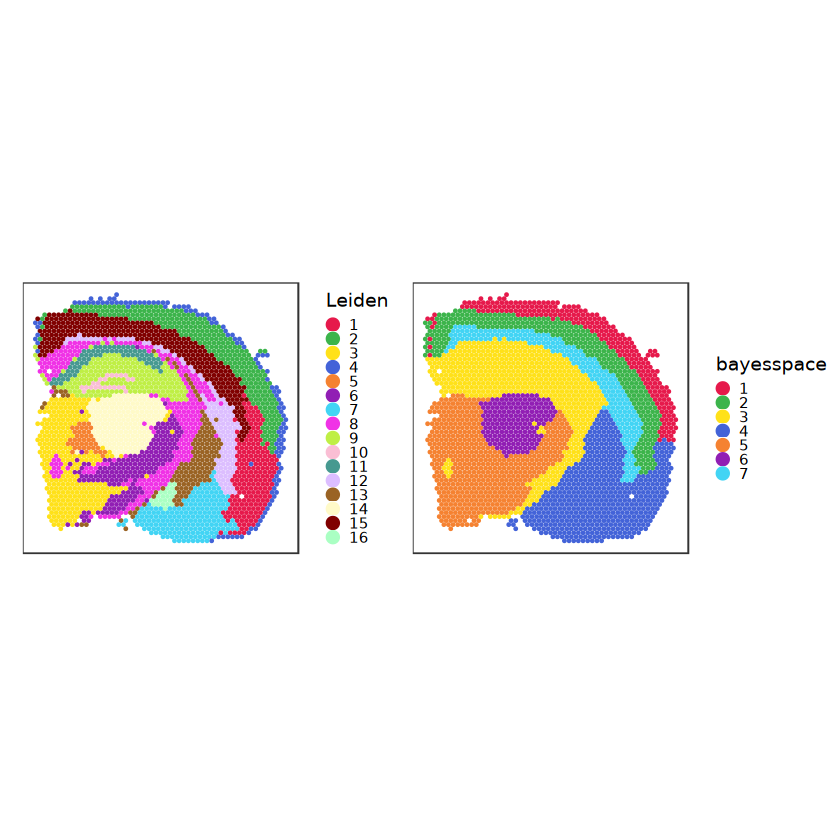

In [3]:
plotSpots(spe, annotate="Leiden") +
plotSpots(spe, annotate="bayesspace") +
    plot_layout() &
    theme(legend.key.size=unit(0, "lines")) &
    scale_color_manual(values=unname(pals::trubetskoy())) 

CHGA	DCX	DPP4	ELP4	FOXA2	FOXO1	G6PC2	GCG	GCK	HNF1A	IAPP	INS	INSM1	ISL1	LMO2	MAFB	NEUROD1	NEUROG3	NKX2-2	NKX6-1	PAK3	PAX4	PAX6	PCSK1	PCSK2	PDX1	PKLR	SCGN	SEC11A	SLC2A2	SPCS1	SRP14	SRP9	SRPRB	SST	STXBP1	SYT13	VDR

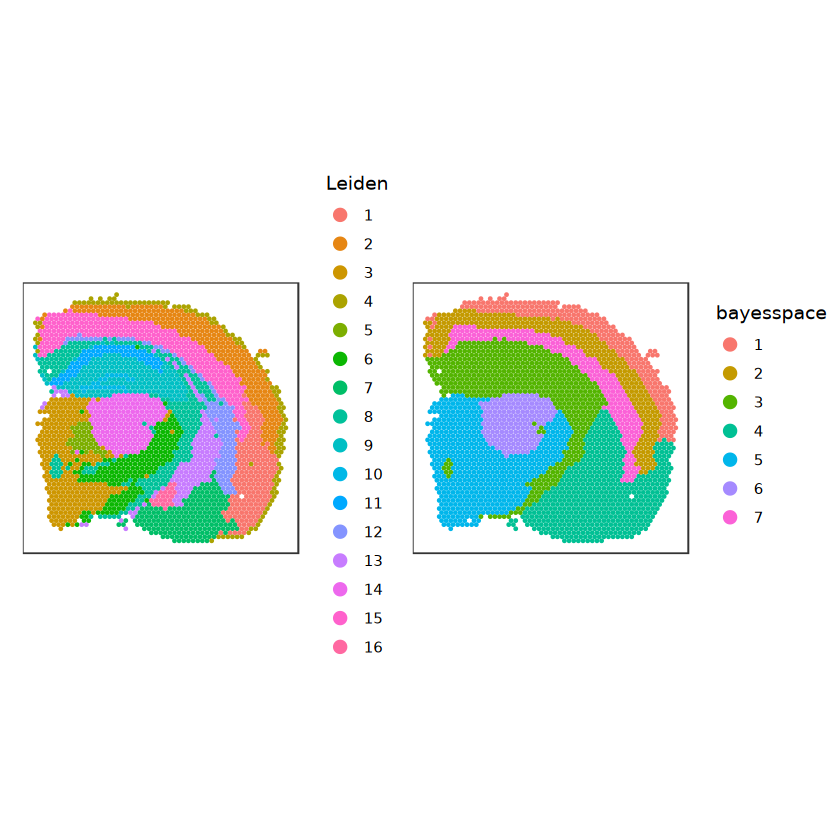

In [ ]:
p1 <- plotSpots(spe, annotate="Leiden")
p2 <- plotSpots(spe, annotate="bayesspace")

p1 + p2

In [29]:
# find marker genes 
mgs <- findMarkers(spe, groups=spe$bayesspace, direction="up")
top <- lapply(mgs, \(df) rownames(df)[df$Top <= 3])
length(top <- unique(unlist(top)))

[1] 67

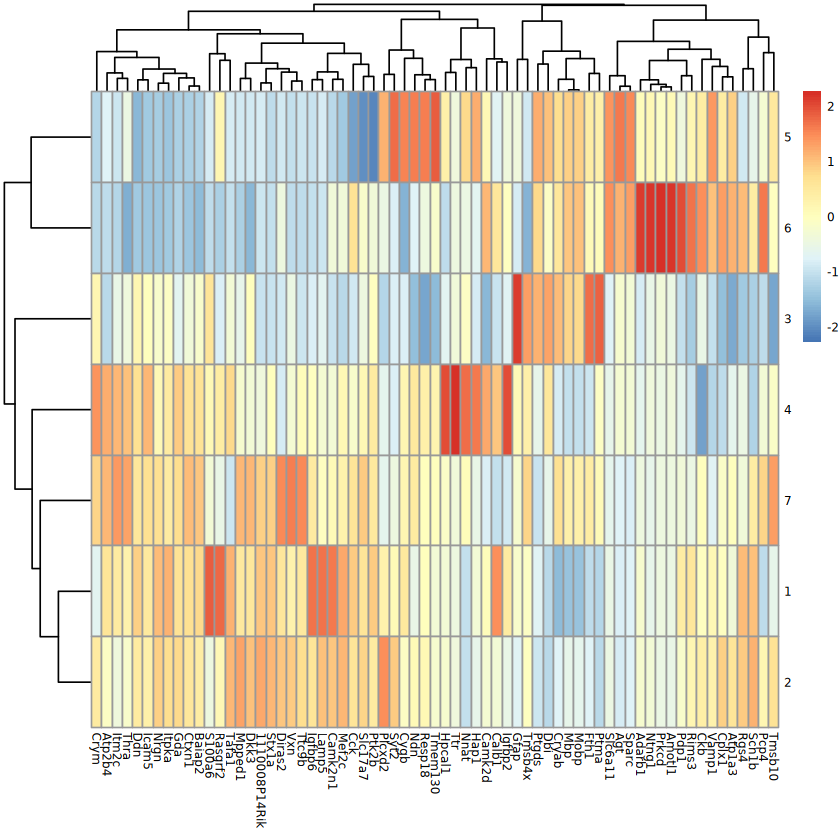

In [30]:
# plot heatmap of top marker genes per cluster
pbs <- aggregateAcrossCells(spe,  
    ids=spe$bayesspace, subset.row=top, 
    use.assay.type="logcounts", statistics="mean")
# use symbols as feature names
mtx <- t(assay(pbs))
colnames(mtx) <- rowData(pbs)$symbol
pheatmap(mat=mtx, scale="column", fontsize = 7)

In [28]:
# save mtx as csv
write.csv(mtx, file="../data/marker_genes.csv", row.names=TRUE)

### Signatures

In [25]:
# look for MSigDB collections
msigdbr_collections()

gs_collection,gs_subcollection,gs_collection_name,num_genesets
<chr>,<chr>,<chr>,<int>
C1,,Positional,302
C2,CGP,Chemical and Genetic Perturbations,3494
C2,CP,Canonical Pathways,19
C2,CP:BIOCARTA,BioCarta Pathways,292
C2,CP:KEGG_LEGACY,KEGG Legacy Pathways,186
C2,CP:KEGG_MEDICUS,KEGG Medicus Pathways,658
C2,CP:PID,PID Pathways,196
C2,CP:REACTOME,Reactome Pathways,1736
C2,CP:WIKIPATHWAYS,WikiPathways,830


In [26]:
# retrieve hallmark gene sets from 'MSigDB'
db <- msigdbr(species="Mus musculus", collection="C5", subcollection = "HPO")
# get list of gene symbols, one element per set
gs <- split(db$ensembl_gene, db$gs_name)
# simplify set identifiers (drop prefix, use lower case)
names(gs) <- tolower(gsub("HALLMARK_", "", names(gs)))
# how many sets?
length(gs)

[1] 5653

In [27]:
rowData(spe)

DataFrame with 32272 rows and 3 columns
                symbol         ensembl_id subsets_mito
           <character>        <character>    <logical>
Xkr4              Xkr4 ENSMUSG00000051951        FALSE
Gm1992          Gm1992 ENSMUSG00000089699        FALSE
Gm19938        Gm19938 ENSMUSG00000102331        FALSE
Gm37381        Gm37381 ENSMUSG00000102343        FALSE
Rp1                Rp1 ENSMUSG00000025900        FALSE
...                ...                ...          ...
AC124606.1  AC124606.1 ENSMUSG00000095523        FALSE
AC133095.2  AC133095.2 ENSMUSG00000095475        FALSE
AC133095.1  AC133095.1 ENSMUSG00000094855        FALSE
AC234645.1  AC234645.1 ENSMUSG00000095019        FALSE
AC149090.1  AC149090.1 ENSMUSG00000095041        FALSE

In [28]:
# realize (sparse) gene expression matrix
mtx <- as(logcounts(spe), "dgCMatrix") 
# use ensembl identifiers as feature names
rownames(mtx) <- rowData(spe)$ensembl_id
# build per-spot gene rankings
rnk <- AUCell_buildRankings(mtx, BPPARAM=bp, plotStats=FALSE, verbose=FALSE)
# calculate AUC for each gene set in each spot
auc <- AUCell_calcAUC(geneSets=gs, rankings=rnk, nCores=th, verbose=FALSE)
# add results as spot metadata
colData(spe)[rownames(auc)] <- res <- t(assay(auc)) 

Warning message in .AUCell_calcAUC(geneSets = geneSets, rankings = rankings, nCores = nCores, :
“The following gene sets will be excluded from the analysis(less than 20% of their genes are available):
hp_leber_optic_atrophy”


In [51]:
spe

class: SpatialExperiment 
dim: 32272 2724 
metadata(0):
assays(2): counts logcounts
rownames(32272): Xkr4 Gm1992 ... AC234645.1 AC149090.1
rowData names(3): symbol ensembl_id subsets_mito
colnames(2724): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCATTAGTCTA-1 TTGTTTCCATACAACT-1
colData names(8318): in_tissue array_row ... zhong_pfc_major_types_npcs
  zhong_pfc_major_types_opc
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):
spatialCoords names(2) : pxl_col_in_fullres pxl_row_in_fullres
imgData names(4): sample_id image_id data scaleFactor

In [29]:
# take top sets
var <- colVars(res)
top <- names(tail(sort(var), 16))

In [30]:
top

[1] "hp_punding"                                           
 [2] "hp_ocular_flutter"                                    
 [3] "hp_eeg_with_frontal_epileptiform_discharges"          
 [4] "hp_focal_head_nodding_automatism_seizure"             
 [5] "hp_posterior_plagiocephaly"                           
 [6] "hp_dysgenesis_of_the_basal_ganglia"                   
 [7] "hp_eeg_with_frontal_focal_spikes"                     
 [8] "hp_photosensitive_myoclonic_seizure"                  
 [9] "hp_frontal_polymicrogyria"                            
[10] "hp_abnormal_serum_bicarbonate_concentration"          
[11] "hp_mixed_demyelinating_and_axonal_polyneuropathy"     
[12] "hp_centrocecal_scotoma"                               
[13] "hp_normal_interictal_eeg"                             
[14] "hp_heinz_bodies"                                      
[15] "hp_eeg_with_centrotemporal_epileptiform_discharges"   
[16] "hp_increased_circulating_interleukin_18_concentration"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is

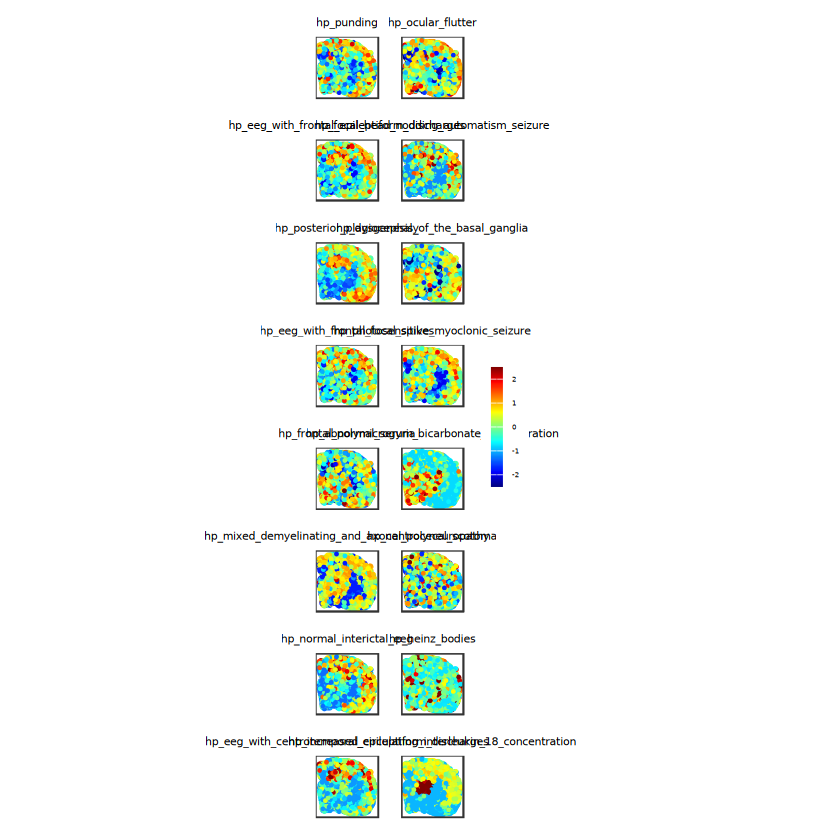

In [31]:
lapply(top, \(.) {
    spe[[.]] <- scale(spe[[.]]) # scaling
    plotSpots(spe, annotate=.) # plotting
}) |> 
    # arrange & prettify
    wrap_plots(ncol=2, guides="collect") & 
    scale_color_gradientn(
        colors=pals::jet(),
        oob=scales::squish, 
        limits=c(-2.5, 2.5)) & 
    theme(
        text = element_text(size = 5),
        legend.key.width=unit(0.5, "lines"), 
        legend.key.height=unit(1, "lines")) 

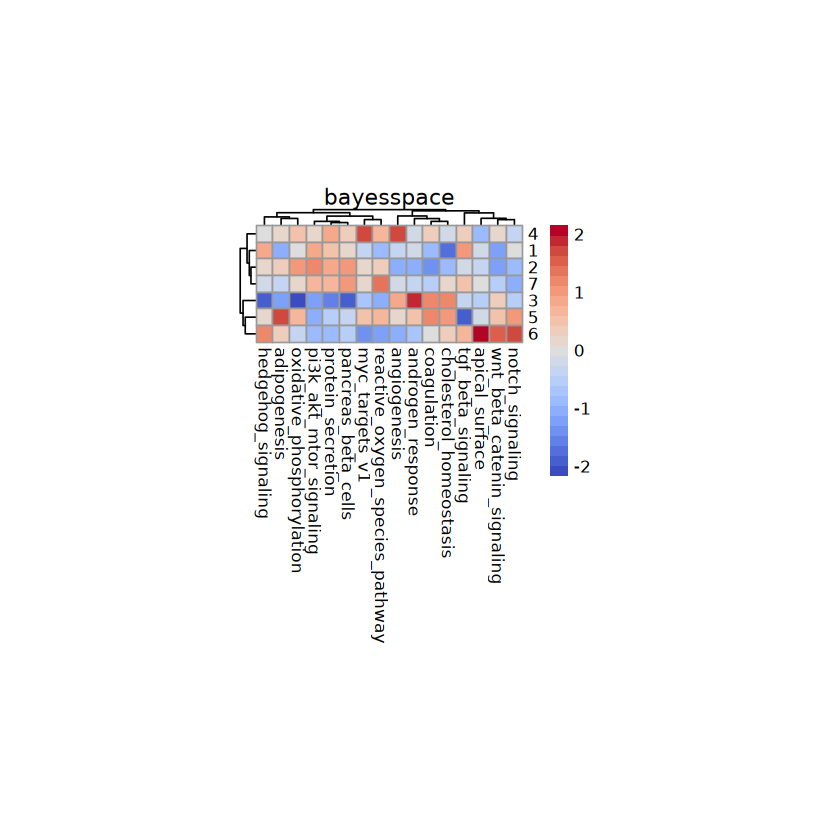

In [57]:
for (. in c("bayesspace")) {
    # aggregate AUC values by cluster
    mu <- aggregateAcrossCells(auc[top, ], spe[[.]], 
        use.assay.type="AUC", statistics="mean")
    # visualize as (cluster x set) heatmap
    pheatmap(
        mat=t(assay(mu)), scale="column", col=pals::coolwarm(), main=.,
        cellwidth=10, cellheight=10, treeheight_row=5, treeheight_col=5)
}

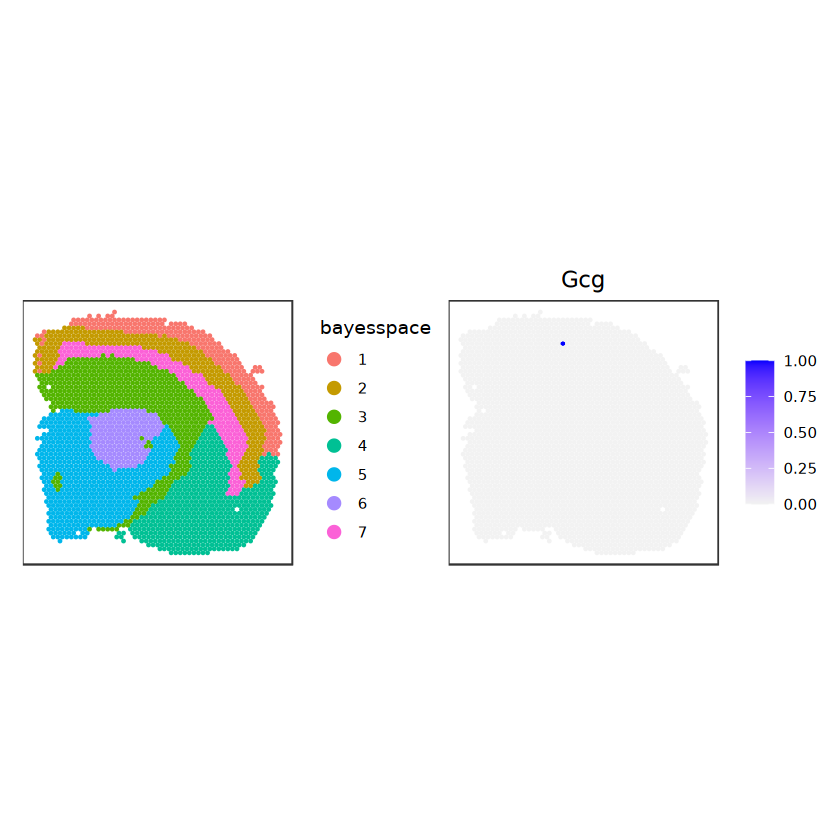

In [ ]:
p1 <- plotSpots(spe, annotate="ABCC8")


p2 + p1


# Ins2 Gcg